
### **Processamento Digital de Imagens - UFPB / 2022.1**


>> **Grupo:** Alexandre Bezerra de Lima  <br> &emsp; &emsp; &ensp; Lucas Gomes Dantas <br> &emsp; &emsp; &ensp; Victor Henrique Felix Brasil <br> &emsp; &emsp; &ensp; Ryann Carlos de Arruda Quintino<br> <br>
>> **Professor** Dr. Leonardo Vidal Batista

***

In [ ]:
from google.colab import drive
drive.mount('Drive')

Mounted at Drive


### **[#] Dependências**

In [ ]:
from PIL import Image 
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

### **[#] Arquivos**

In [ ]:
def load_filter_data(filter_name):
  offset = None
  kernel_stage = False
  kernel = []
  pivot = {'row': -1, 'column': -1}

  with open(filter_name, 'r') as f:
    lines = f.readlines()

    for i in lines:

      if kernel_stage and not re.search('(pivot)\=', i):
        row = list(map(float, i.split()))
        kernel.append(row)
      
      if re.search('(offset)\=',i):
        offset = int(i.split('=')[1])
      
      elif re.search('(kernel)\=', i):
        kernel_stage = True
      
      elif re.search('(pivot)\=', i):
        kernel_stage = False
        values = list(map(int, i.split('=')[1].split(',')))
        pivot['row'] = values[0]
        pivot['column'] = values[1]

  kernel = np.asarray(kernel)

  return (offset, kernel, pivot)

### **[*] Carregando Imagens**

In [ ]:
os.chdir('/content/Drive/MyDrive/PDI/Imagens') # Acessa o diretório da imagem
os.getcwd() # Retorna o diretório atual
os.listdir() # Lista os arquivos do diretório

['testpat.1k.color.tif',
 'Shapes.png',
 'DancingInWater.jpg',
 'fruits.jpg',
 'veiaPDI.png']

In [ ]:
image = Image.open('veiaPDI.png') # Abre a imagem
print('Mode: {0}'.format(image.mode)) # Recupera o espaço de cores utilizado pela imagem
print('Size: {0}'.format(image.size)) # Recupera o tamanho da imagem (pixels)

Mode: RGBA
Size: (465, 310)


Text(0.5, 1.0, 'Current Image')

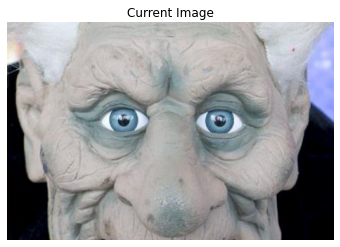

In [ ]:
plt.imshow(image) # Exibe a imagem
plt.axis('off')
plt.title('Current Image')

### **[*] Separando em Canais**

Text(0.5, 1.0, 'Blue')

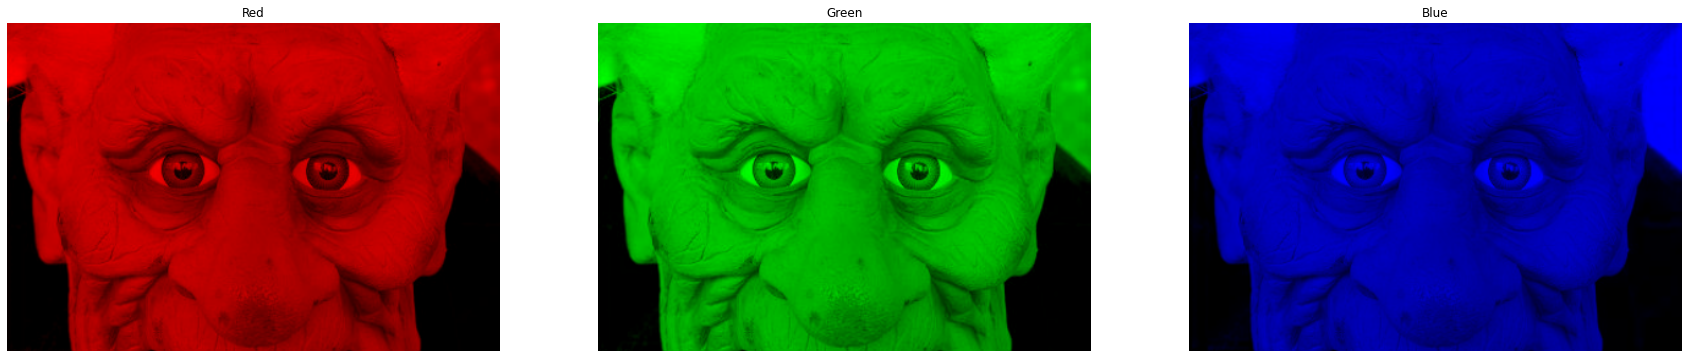

In [ ]:
fig = plt.figure(figsize=(30,10))

'''
Faço três cópias para cada canal
''' 
image_array_red = np.array(image)
image_array_green = np.array(image)
image_array_blue = np.array(image)

fig.add_subplot(1,3,1)

'''
Zero as componente VERDE e AZUL
'''
image_array_red[:,:,1] *= 0
image_array_red[:,:,2] *= 0
plt.imshow(image_array_red)
plt.axis('off')
plt.title('Red')

fig.add_subplot(1,3,2)

'''
Zero as componentes VERMELHO e AZUL
'''
image_array_green[:,:,0] *= 0
image_array_green[:,:,2] *= 0
plt.imshow(image_array_green)
plt.axis('off')
plt.title('Green')

fig.add_subplot(1,3,3)

'''
Zero as componentes VERMELHO e VERDE
'''
image_array_blue[:,:,0] *= 0
image_array_blue[:,:,1] *= 0
plt.imshow(image_array_blue)
plt.axis('off')
plt.title('Blue')

### **[*] RGB-YIQ-RGB**

In [ ]:
'''
LIMITES DO RGB
''' 
def limiter(val):
  if val > 255:
    return 255
  elif val < 0:
    return 0
  
  return val

In [ ]:
'''
CONVERSÃO RGB -> YIQ
'''
def rgb_to_yiq(rgb):
  yiq = np.array(image,dtype=float)

  yiq[:,:,0] = (0.299)*rgb[:,:,0] + (0.587)*rgb[:,:,1] + (0.114)*rgb[:,:,2]
  yiq[:,:,1] = (0.596)*rgb[:,:,0] - (0.274)*rgb[:,:,1] - (0.322)*rgb[:,:,2]
  yiq[:,:,2] = (0.211)*rgb[:,:,0] - (0.523)*rgb[:,:,1] + (0.312)*rgb[:,:,2]

  return yiq

'''
CONVERSÃO YIQ -> RGB
'''
def yiq_to_rgb(yiq):
  rows, columns, components = np.shape(yiq)
  rgb = np.zeros((rows, columns, 3), dtype=int)

  for i in range(rows):
    for j in range(columns):
      rgb[i][j][0] = limiter(yiq[i][j][0] + (0.956)*yiq[i][j][1] + (0.621)*yiq[i][j][2])
      rgb[i][j][1] = limiter(yiq[i][j][0] - (0.272)*yiq[i][j][1] - (0.647)*yiq[i][j][2])
      rgb[i][j][2] = limiter(yiq[i][j][0] - (1.106)*yiq[i][j][1] + (1.703)*yiq[i][j][2])
  
  return rgb

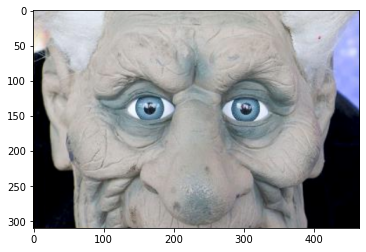

In [ ]:
'''
CHAMADA DAS FUNÇÕES
'''
rgb = np.array(image)
rgb = rgb_to_yiq(rgb)
rgb = yiq_to_rgb(rgb)

plt.imshow(rgb)

### **[*] Negativo**

>> #### **Negativo em RGB**

In [ ]:
'''
APLICAÇÃO DO NEGATIVO > L-1-R
'''
def rgb_neg(image_arr):
  image_arr[:,:,0] = 255 - image_arr[:,:,0]
  image_arr[:,:,1] = 255 - image_arr[:,:,1]
  image_arr[:,:,2] = 255 - image_arr[:,:,2]

Text(0.5, 1.0, 'Negative')

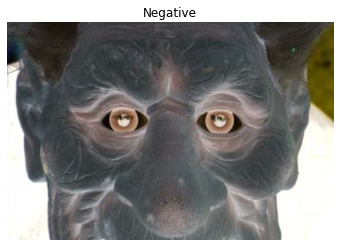

In [ ]:
image_arr = np.array(image)
rgb_neg(image_arr)

plt.imshow(image_arr)
plt.axis('off')
plt.title('Negative')

### **[*] Negativo em YIQ**

In [ ]:
def yiq_neg(rgb):
  yiq = rgb_to_yiq(rgb)

  yiq[:,:,0] = 255 - yiq[:,:,0]

  return yiq_to_rgb(yiq)

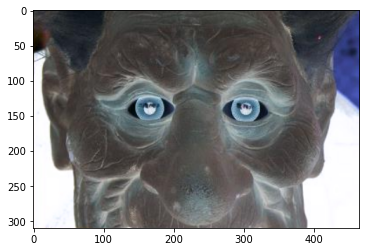

In [ ]:
rgb = np.array(image)

rgb = yiq_neg(rgb)

plt.imshow(rgb)

### **[*] Kernels**

>> #### Extensão por Zeros

In [ ]:
def zero_extension(image_arr, r_filter, c_filter, pivot_row, pivot_column):
  rows, columns, components = np.shape(image_arr)
  
  zero_row_add = (r_filter - 1)//2
  zero_column_add = (c_filter - 1)//2

  '''
    Descobrimos qual das componentes do pivô possui maior relevância
  '''
  pivot_row -= zero_row_add
  pivot_column -= zero_column_add

  if pivot_row < 0:
    pivot_row *= -1
  elif pivot_column < 0:
    pivot_column *= -1
  
  '''
  Recuperamos qual o maior valor de relevância (linha ou coluna do pivô)
  '''
  result = max(pivot_row, pivot_column)

  '''
     Adicionamos ao número de linhas e colunas o valor de relevância que a posição do pivô possui
     na adição de linhas e colunas com zero
  '''
  zero_row_add += result
  zero_column_add += result

  '''
    rows = número de linhas na matriz original
    zero_column_add = número de colunas a serem adicionadas
  '''
  zero_column = np.zeros((rows, zero_column_add))  # (COLUNA) 
  zero_line = np.zeros((zero_row_add, columns + zero_column_add * 2))# (LINHA) 

  extended_image_arr = np.zeros((rows + zero_row_add*2, columns + zero_column_add*2, 3))
                
  image_arr_red = np.append(zero_column, image_arr[:,:,0], axis = 1) # coluna antes
  image_arr_red = np.append(image_arr_red, zero_column, axis = 1) # colunas depois

  image_arr_green = np.append(zero_column, image_arr[:,:,1], axis = 1) # coluna antes
  image_arr_green = np.append(image_arr_green, zero_column, axis = 1) # colunas depois

  image_arr_blue = np.append(zero_column, image_arr[:,:,2], axis = 1) # coluna antes
  image_arr_blue = np.append(image_arr_blue, zero_column, axis = 1) # colunas depois  

  '''
    zero_row_add = número de linhas a serem adicionadas
    columns + zero_column_add * 2 = número de colunas na matriz original + (número de colunas a serem adicionadas * 2), multiplicamos por 2 pois é em cima e em baixo
  '''
  image_arr_red = np.append(zero_line, image_arr_red, axis = 0) # linha antes
  image_arr_red = np.append(image_arr_red, zero_line, axis = 0) # linha depois

  image_arr_green = np.append(zero_line, image_arr_green, axis = 0) # linha antes
  image_arr_green = np.append(image_arr_green, zero_line, axis = 0) # linha depois

  image_arr_blue = np.append(zero_line, image_arr_blue, axis = 0) # linha antes
  image_arr_blue = np.append(image_arr_blue, zero_line, axis = 0) # linha depois

  extended_image_arr[:,:,0] = image_arr_red
  extended_image_arr[:,:,1] = image_arr_green
  extended_image_arr[:,:,2] = image_arr_blue

  return (extended_image_arr, zero_row_add, zero_column_add)

>> #### Filtro da Mediana

In [ ]:
def median_filter(image_array, r_filter, c_filter, pivot_row, pivot_column):
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, r_filter, c_filter, pivot_row, pivot_column)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      filter_shape = [[],[],[]]
      
      for m in range(i - pivot_row, i + (r_filter - pivot_row)):
        for n in range(j - pivot_column, j + (c_filter - pivot_column)):
          filter_shape[0].append(image_array[m][n][0])
          filter_shape[1].append(image_array[m][n][1])
          filter_shape[2].append(image_array[m][n][2])
      
      filter_shape[0].sort()
      filter_shape[1].sort()
      filter_shape[2].sort()
      result_image[i - rows_add][j - columns_add][0] = filter_shape[0][len(filter_shape[0])//2]
      result_image[i - rows_add][j - columns_add][1] = filter_shape[1][len(filter_shape[1])//2]
      result_image[i - rows_add][j - columns_add][2] = filter_shape[2][len(filter_shape[2])//2]
  
  return result_image

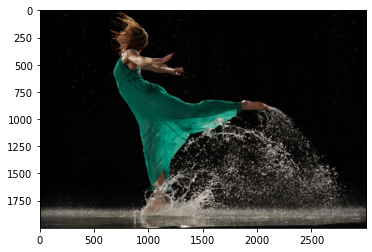

In [ ]:
image_arr = np.array(image)

image_arr = median_filter(image_arr, 9,9,4,4)

plt.imshow(image_arr)

>> #### Filtro da Média

In [ ]:
def mean_filter(image_array, filter, pivot, offset):
  result_image = image_array.copy()

  r_filter, c_filter = np.shape(filter)
  pivot_row = pivot['row']
  pivot_column = pivot['column']
  
  image_array, rows_add, columns_add = zero_extension(image_array, r_filter, c_filter, pivot_row, pivot_column)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      result_red = 0.0
      result_green = 0.0
      result_blue = 0.0
      
      for m in range(i - pivot_row, i + (r_filter - pivot_row)):
        aux = m % r_filter

        for n in range(j - pivot_column, j + (c_filter - pivot_column)):
          result_red += image_array[m][n][0]*filter[aux][n % c_filter]
          result_green += image_array[m][n][1]*filter[aux][n % c_filter]
          result_blue += image_array[m][n][2]*filter[aux][n % c_filter]
      
      result_image[i - rows_add][j - columns_add][0] = limiter(result_red + offset)
      result_image[i - rows_add][j - columns_add][1] = limiter(result_green + offset)
      result_image[i - rows_add][j - columns_add][2] = limiter(result_blue + offset)
  
  return result_image

### **[*] RGB-HSB-RGB**

In [ ]:
def rgb_to_hsb(image_arr):
  rows, columns, components = np.shape(image_arr)
  image_array = np.zeros((rows, columns, 3), dtype=float)

  for i in range(rows):
    for j in range(columns):
      R_color = image_arr[i][j][0]
      G_color = image_arr[i][j][1]
      B_color = image_arr[i][j][2]

      r = R_color/255
      g = G_color/255
      b = B_color/255

      c_max = max(r,g)
      c_max = max(c_max, b)

      c_min = min(r,g)
      c_min = min(c_min,b)

      delta = c_max - c_min

      H = -1
      if delta == 0:
        H = 0
      elif c_max == r:
        H = 60 * (((g - b)/delta)%6)
      elif c_max == g:
        H = 60 * (((b - r)/delta) + 2)
      elif c_max == b:
        H = 60 * (((r - g)/delta) + 4)
      
      S = -1
      if c_max == 0:
        S = 0
      else:        
        S = delta/c_max

      B = c_max

      image_array[i][j][0] = H
      image_array[i][j][1] = S
      image_array[i][j][2] = B
  
  return image_array

In [ ]:
def hsb_to_rgb(image_arr):
  rows, columns, components = np.shape(image_arr)
  arr = np.zeros((rows, columns, 3), dtype=int)

  for i in range(rows):
    for j in range(columns):
      H = image_arr[i][j][0]
      S = image_arr[i][j][1]
      B = image_arr[i][j][2]

      c = B * S
      x = c * (1 - abs((H / 60)%2 - 1))
      m = B - c

      r = 0
      g = 0
      b = 0

      if H >= 0 and H < 60:
        r = c
        g = x
        b = 0

      elif H >= 60 and H < 120:
        r = x
        g = c
        b = 0

      elif H >= 120 and H < 180:
        r = 0
        g = c
        b = x

      elif H >= 180 and H < 240:
        r = 0
        g = x
        b = c

      elif H >= 240 and H < 300:
        r = x
        g = 0
        b = c

      elif H >= 300 and H < 360:
        r = c
        g = 0
        b = x

      arr[i][j][0] = (r + m)*255
      arr[i][j][1] = (g + m)*255
      arr[i][j][2] = (b + m)*255

  return arr

In [ ]:
def limiter_saturation(val):
  if val > 1:
    return 1
  elif val < 0:
    return 0
  
  return val

In [ ]:
def control_saturation(image_arr, saturation_add):
  rows, columns, components = np.shape(image_arr)
  image_arr_hsb = rgb_to_hsb(image_arr)

  for i in range(rows):
    for j in range(columns):
      image_arr_hsb[i][j][1] = limiter_saturation(image_arr_hsb[i][j][1] + saturation_add)
  
  return hsb_to_rgb(image_arr_hsb)

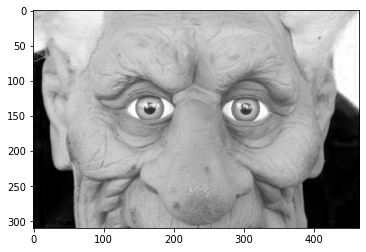

In [ ]:
image_arr = np.array(image)

image_arr = control_saturation(image_arr, -1.0)

plt.imshow(image_arr)

### **[*] Sobel**

In [ ]:
def horizontal_sobel_filter(image_array, mask, offset):
  horizontal_sobel = mask
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, 3, 3, 1, 1)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      result_red =  abs(image_array[i + 1][j - 1][0]*horizontal_sobel[2][0] + image_array[i + 1][j][0]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][0]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][0]*horizontal_sobel[0][0] + image_array[i - 1][j][0]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][0]*horizontal_sobel[0][2])
      result_green =  abs(image_array[i + 1][j - 1][1]*horizontal_sobel[2][0] + image_array[i + 1][j][1]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][1]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][1]*horizontal_sobel[0][0] + image_array[i - 1][j][1]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][1]*horizontal_sobel[0][2])
      result_blue =  abs(image_array[i + 1][j - 1][2]*horizontal_sobel[2][0] + image_array[i + 1][j][2]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][2]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][2]*horizontal_sobel[0][0] + image_array[i - 1][j][2]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][2]*horizontal_sobel[0][2])

      result_image[i - rows_add][j - columns_add][0] = limiter(result_red + offset)
      result_image[i - rows_add][j - columns_add][1] = limiter(result_green + offset)
      result_image[i - rows_add][j - columns_add][2] = limiter(result_blue+ offset)
  
  return result_image

In [ ]:
def vertical_sobel_filter(image_array, mask, offset):
  vertical_sobel = mask
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, 3, 3, 1, 1)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      result_red =  abs(image_array[i - 1][j + 1][0]*vertical_sobel[0][2] + image_array[i][j + 1][0]*vertical_sobel[1][2] + image_array[i + 1][j + 1][0]*vertical_sobel[2][2] + image_array[i - 1][j - 1][0]*vertical_sobel[0][0] + image_array[i][j - 1][0]*vertical_sobel[1][0] + image_array[i + 1][j - 1][0]*vertical_sobel[2][0])
      result_green =  abs(image_array[i - 1][j + 1][1]*vertical_sobel[0][2] + image_array[i][j + 1][1]*vertical_sobel[1][2] + image_array[i + 1][j + 1][1]*vertical_sobel[2][2] + image_array[i - 1][j - 1][1]*vertical_sobel[0][0] + image_array[i][j - 1][1]*vertical_sobel[1][0] + image_array[i + 1][j - 1][1]*vertical_sobel[2][0])
      result_blue =  abs(image_array[i - 1][j + 1][2]*vertical_sobel[0][2] + image_array[i][j + 1][2]*vertical_sobel[1][2] + image_array[i + 1][j + 1][2]*vertical_sobel[2][2] + image_array[i - 1][j - 1][2]*vertical_sobel[0][0] + image_array[i][j - 1][2]*vertical_sobel[1][0] + image_array[i + 1][j - 1][2]*vertical_sobel[2][0])

      result_image[i - rows_add][j - columns_add][0] = (result_red + offset)
      result_image[i - rows_add][j - columns_add][1] = (result_green + offset)
      result_image[i - rows_add][j - columns_add][2] = (result_blue + offset)
  
  return result_image

In [ ]:
def sobel_filter(image_array, mask_horizontal, mask_vertical):
  horizontal_sobel = mask_horizontal
  vertical_sobel = mask_vertical
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, 3, 3, 1, 1)
  rows, columns, components = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      result_red =  abs(image_array[i + 1][j - 1][0]*horizontal_sobel[2][0] + image_array[i + 1][j][0]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][0]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][0]*horizontal_sobel[0][0] + image_array[i - 1][j][0]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][0]*horizontal_sobel[0][2])
      result_green =  abs(image_array[i + 1][j - 1][1]*horizontal_sobel[2][0] + image_array[i + 1][j][1]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][1]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][1]*horizontal_sobel[0][0] + image_array[i - 1][j][1]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][1]*horizontal_sobel[0][2])
      result_blue =  abs(image_array[i + 1][j - 1][2]*horizontal_sobel[2][0] + image_array[i + 1][j][2]*horizontal_sobel[2][1] + image_array[i + 1][j + 1][2]*horizontal_sobel[2][2] + image_array[i - 1][j - 1][2]*horizontal_sobel[0][0] + image_array[i - 1][j][2]*horizontal_sobel[0][1] + image_array[i - 1][j + 1][2]*horizontal_sobel[0][2])

      result_red +=  abs(image_array[i - 1][j + 1][0]*vertical_sobel[0][2] + image_array[i][j + 1][0]*vertical_sobel[1][2] + image_array[i + 1][j + 1][0]*vertical_sobel[2][2] + image_array[i - 1][j - 1][0]*vertical_sobel[0][0] + image_array[i][j - 1][0]*vertical_sobel[1][0] + image_array[i + 1][j - 1][0]*vertical_sobel[2][0])
      result_green +=  abs(image_array[i - 1][j + 1][1]*vertical_sobel[0][2] + image_array[i][j + 1][1]*vertical_sobel[1][2] + image_array[i + 1][j + 1][1]*vertical_sobel[2][2] + image_array[i - 1][j - 1][1]*vertical_sobel[0][0] + image_array[i][j - 1][1]*vertical_sobel[1][0] + image_array[i + 1][j - 1][1]*vertical_sobel[2][0])
      result_blue +=  abs(image_array[i - 1][j + 1][2]*vertical_sobel[0][2] + image_array[i][j + 1][2]*vertical_sobel[1][2] + image_array[i + 1][j + 1][2]*vertical_sobel[2][2] + image_array[i - 1][j - 1][2]*vertical_sobel[0][0] + image_array[i][j - 1][2]*vertical_sobel[1][0] + image_array[i + 1][j - 1][2]*vertical_sobel[2][0])

      result_image[i - rows_add][j - columns_add][0] = (result_red + offset)
      result_image[i - rows_add][j - columns_add][1] = (result_green + offset)
      result_image[i - rows_add][j - columns_add][2] = (result_blue + offset)
  
  return result_image

### **[*] Histograma - Sobel**

>> #### Expansão do Histograma

In [ ]:
def expansion_histogram(image_array):
  flat_image = image_array.flatten()
  flat_image.sort()

  L = 256

  r_max = flat_image[len(flat_image) - 1]
  r_min = flat_image[0]

  counted = Counter(flat_image)

  keys = counted.keys()

  expansion = {}

  for r in range(0, 256):
    expansion[r] = round(((counted[r] - r_min) / (r_max - r_min)) * (L - 1))
  
  print(f'here: {counted}')

  return expansion

In [ ]:
image_arr = np.array(image)

exp = expansion_histogram(image_arr)

here: Counter({255: 145292, 0: 31464, 187: 6421, 186: 6290, 188: 6288, 185: 6228, 184: 6112, 189: 6111, 191: 6069, 183: 6058, 190: 6018, 182: 5845, 181: 5835, 192: 5757, 180: 5717, 193: 5658, 179: 5515, 177: 5371, 178: 5353, 194: 5324, 176: 5246, 172: 5145, 175: 5079, 173: 4991, 195: 4981, 174: 4954, 2: 4943, 171: 4754, 196: 4711, 169: 4629, 170: 4597, 1: 4503, 168: 4484, 166: 4374, 167: 4294, 197: 4228, 165: 4043, 164: 3955, 198: 3842, 163: 3815, 162: 3711, 161: 3646, 160: 3629, 199: 3610, 159: 3552, 158: 3420, 157: 3375, 155: 3323, 156: 3303, 200: 3199, 153: 3122, 154: 3116, 150: 3031, 152: 3026, 151: 3004, 148: 2925, 149: 2886, 201: 2857, 147: 2848, 146: 2812, 145: 2684, 144: 2564, 4: 2512, 202: 2499, 142: 2484, 143: 2436, 141: 2339, 140: 2336, 203: 2200, 139: 2178, 138: 2132, 137: 2124, 136: 2112, 135: 1945, 133: 1937, 204: 1917, 134: 1916, 3: 1912, 132: 1837, 205: 1819, 130: 1724, 129: 1716, 131: 1705, 128: 1631, 206: 1572, 127: 1524, 125: 1517, 126: 1475, 207: 1475, 5: 1414, 123:

<BarContainer object of 256 artists>

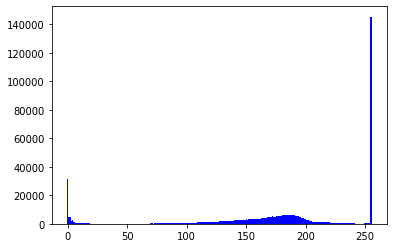

In [ ]:
plt.bar(exp.keys(), exp.values(), 1.0, color='b')

### **[#] Main**

In [ ]:
'''
os.chdir('PDI/Masks') # Acessa o diretório da imagem
os.getcwd() # Retorna o diretório atual
os.listdir() # Lista os arquivos do diretório
'''

"\nos.chdir('PDI/Masks') # Acessa o diretório da imagem\nos.getcwd() # Retorna o diretório atual\nos.listdir() # Lista os arquivos do diretório\n"

In [ ]:
image2 = Image.open('veiaPDI.png') # Abre a imagem
print('Mode: {0}'.format(image.mode)) # Recupera o espaço de cores utilizado pela imagem
print('Size: {0}'.format(image.size)) # Recupera o tamanho da imagem (pixels)

Mode: RGBA
Size: (465, 310)


In [ ]:
os.chdir('/content/Drive/MyDrive/PDI/Masks') # Acessa o diretório da imagem
os.getcwd() # Retorna o diretório atual
os.listdir() # Lista os arquivos do diretório

['media49x49.txt',
 'media3x3.txt',
 'sobel_vertical.txt',
 'sobel_horizontal.txt']

In [ ]:
os.chdir('/content/Drive/MyDrive/PDI/Imagens') # Acessa o diretório da imagem
os.getcwd() # Retorna o diretório atual
os.listdir() # Lista os arquivos do diretório

['testpat.1k.color.tif',
 'Shapes.png',
 'DancingInWater.jpg',
 'fruits.jpg',
 'veiaPDI.png']

>> #### Média

In [ ]:
offset, mask, pivot = load_filter_data('media49x49.txt')

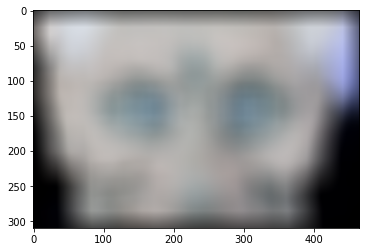

In [ ]:
image_array = np.array(image)

image_array = mean_filter(image_array,  mask, pivot, offset)

plt.imshow(image_array)

>> #### Sobel - Horizontal

In [ ]:
offset, mask, pivot = load_filter_data('sobel_horizontal.txt')

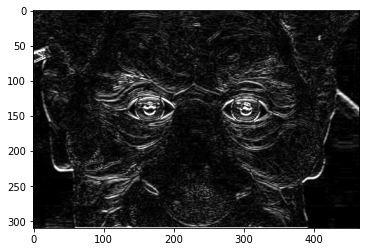

In [ ]:
image_array = np.array(image)

image_array = control_saturation(image_array, -2)

image_array = horizontal_sobel_filter(image_array, mask, offset)

plt.imshow(image_array)

>> #### Sobel - Vertical

In [ ]:
offset, mask, pivot = load_filter_data('sobel_vertical.txt')

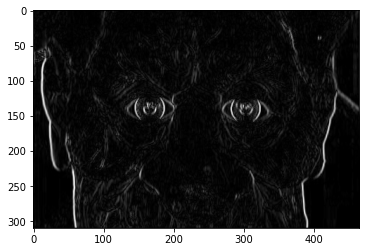

In [ ]:
image_array = np.array(image)

image_array = control_saturation(image_array, -2)

image_array = horizontal_sobel_filter(image_array, mask, offset)

plt.imshow(image_array)

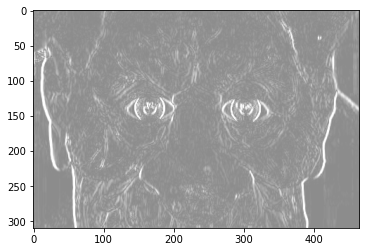

In [ ]:
'''
OFFSET SOBREL HORIZONTAL
- Descobrimos que o Offset nada mais é que uma alteração nos níveis de brilho da imagem,
  através dessa descoberta, gerenciamos o desenvolvimento da aplicação do mesmo nos filtros
'''
image_arr = np.array(image)

image_arr = control_saturation(image_arr, -2.0)

image_arr = horizontal_sobel_filter(image_arr, mask, 140) #Modificação no brilho, representando o Offset

plt.imshow(image_arr)

>> #### Sobel + Histograma

In [ ]:
offset, mask_horizontal, pivot = load_filter_data('sobel_horizontal.txt')
offset, mask_vertical, pivot = load_filter_data('sobel_vertical.txt')

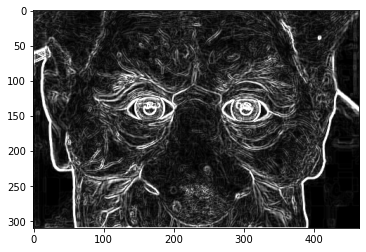

In [ ]:
image_array = np.array(image)

image_array = control_saturation(image_array, -2)

image_array = sobel_filter(image_array, mask_horizontal, mask_vertical)

plt.imshow(image_array)

In [ ]:
exp_hist = expansion_histogram(image_array)

here: Counter({0: 17136, 12: 16482, 8: 16473, 16: 15984, 18: 14940, 20: 14832, 14: 14643, 22: 13971, 10: 13797, 4: 13635, 24: 12930, 26: 12861, 28: 11745, 30: 11388, 32: 11064, 34: 10158, 6: 10110, 36: 9792, 38: 8982, 40: 8547, 42: 7716, 44: 7575, 46: 7113, 48: 6372, 50: 6267, 52: 6102, 54: 5817, 56: 5241, 58: 4962, 60: 4770, 2: 4572, 62: 4470, 64: 4074, 66: 3990, 68: 3588, 70: 3501, 72: 3249, 74: 3048, 76: 2883, 80: 2715, 78: 2643, 82: 2460, 84: 2409, 88: 2268, 86: 2250, 92: 2004, 90: 1935, 94: 1935, 96: 1680, 98: 1635, 100: 1614, 102: 1581, 104: 1497, 112: 1410, 106: 1389, 110: 1347, 108: 1248, 116: 1170, 114: 1158, 118: 1134, 124: 1083, 122: 1080, 120: 1032, 126: 1011, 128: 825, 132: 813, 134: 810, 136: 801, 130: 780, 140: 735, 142: 732, 138: 729, 144: 714, 146: 678, 148: 597, 154: 594, 150: 591, 152: 570, 160: 534, 158: 525, 156: 495, 162: 495, 164: 468, 166: 459, 168: 447, 172: 429, 170: 426, 174: 366, 182: 366, 176: 363, 178: 360, 180: 345, 188: 330, 186: 315, 200: 315, 184: 306,

<BarContainer object of 256 artists>

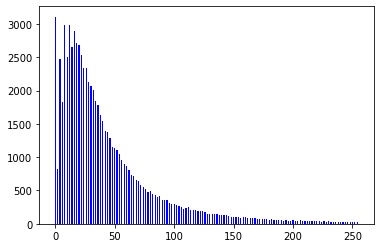

In [ ]:
plt.bar(exp_hist.keys(), exp_hist.values(), 1.0, color='b')